### **Pruning** ###

This notebook prunes the YOLO-DATA-V1 dataset created by the Preprocessing notebook from RAMP-DATA-V0. It's purpose is to create YOLO-DATA-V2 to improve image-label quality and YOLO-DATA-V3 to test model sensitivity to scale.


Below are the key highlights accomplished in this notebook.

1. YOLO-DATA-V2
    - Downloaded Model 1 that was trained on YOLO-DATA-V1
    - Ran inference on YOLO-DATA-V1 and calculated metrics
    - Analyzed the distribution of the inference scores
    - Presumed that the fat left tail of the distribution are labeling errors and removed them from DATA-V1 to generate DATA-V2. Removed data was ~4%.

2. YOLO-DATA-V3
    - Obtained the image scaling information from the TIF files in DATA-V0. These values are in meters per pixel. Note: Zoom Level 19 is at 0.3 meters per pixel.
    - Determined the range of scale in the dataset to be (0.3, 0.52) for x and (0.3, 0.53) for y.
    - Reviewed the distribution of the scale and found most images are between (0.3, 0.4)
    - Removed all images with scale greater than 0.4 from DATA-V2 to generate DATA-V3.


In [ ]:
!pip3 install -q ultralytics
!pip3 install -q rasterio
!pip3 install -q pyproj
!pip3 install -q affine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 755.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.5/865.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 87.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import glob
import os
import cv2
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from pyproj import Transformer
from affine import Affine

In [25]:
# Download YOLO-DATA-V1 from GDrive
# !gdown --fuzzy https://drive.google.com/file/d/10XGskgMGdkXTqbGDGu9BRtJklq_lfFTd/view?usp=sharing
!unzip -q data1*.zip

# Download the YOLO model based on DATA-V1
# !gdown --fuzzy https://drive.google.com/file/d/1sVhN2xxSa6ZlhArFCSEc3bxVUXWS5QQb/view?usp=sharing
# !unzip -q yolo_model*.zip

[data1_ramp_data_yolo.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data1_ramp_data_yolo.zip or
        data1_ramp_data_yolo.zip.zip, and cannot find data1_ramp_data_yolo.zip.ZIP, period.


### YOLO-DATA-V2 ###

In [ ]:
# Define the path to the folders and find all folders
YOLO_FOLDERS = 'ramp_data_yolo/*/images'

# List to store all jpegs with path
jwps = []

# Collect all JPEG files from each folder and print the count in each folder
for folder in glob.glob(YOLO_FOLDERS, recursive=True):
    jpeg_files = glob.glob(f'{folder}/*.jpg')
    print(f'Folder {folder}: {len(jpeg_files)}')
    jwps.extend(jpeg_files)

print(len(jwps))

0


In [ ]:
# Create inference folder if it does not exist
if not os.path.exists('masks'):
    os.makedirs('masks')
    os.makedirs('masks/inference')
    os.makedirs('masks/gt')

In [ ]:
# Load our model
MODEL = '/content/ramp_data_yolo_500e/weights/best.pt'
model = YOLO(MODEL)

# Define a function to generate inference masks
def generate_inference_mask(jwp, CLSS=0, IOU=0.2, model=model):
    img = cv2.imread(jwp)
    results = model.predict(source=img.copy(), save=False, save_txt=False, stream=True, iou=IOU, verbose=False)

    # Default to a fully black mask if no detections are found
    clss_mask = torch.zeros_like(torch.tensor(img[:, :, 0]))  # Create a black mask with the same dimensions as the input image

    for result in results:
        if result is None or result.masks is None:
            continue  # Skip if no detections are found

        # Get array results
        masks = result.masks.data
        boxes = result.boxes.data

        # Extract classes
        clss = boxes[:, 5]

        # Get indices of results where class is CLSS
        indices = torch.where(clss == CLSS)[0]

        if len(indices) > 0:
            # Use these indices to extract the relevant masks
            clss_masks = masks[indices]

            # Logical OR across all masks to combine them
            clss_mask = torch.any(clss_masks, dim=0).int() * 255

    # Save to file
    fn = os.path.basename(jwp)
    cv2.imwrite(f'masks/inference/{fn}', clss_mask.cpu().numpy())

In [ ]:
def generate_gt_mask(lwp):
    # Read the text file with polygon coordinates
    with open(lwp, 'r') as f:
        lines = f.readlines()

    # Create an empty black image of size 256x256
    mask = np.zeros((256, 256), dtype=np.uint8)

    # Check if the file is not empty
    if not lines:
        fn = os.path.basename(lwp).replace('.txt', '.jpg')
        cv2.imwrite(f'masks/gt/{fn}', mask)

    for line in lines:
        # Split the line into parts and ignore the first element (0)
        parts = line.strip().split()[1:]

        # Convert the normalized coordinates to actual pixel values in the range 0-256
        points = np.array([[int(float(x) * 256), int(float(y) * 256)] for x, y in zip(parts[0::2], parts[1::2])], dtype=np.int32)

        # Draw the polygon
        cv2.fillPoly(mask, [points], 1)  # 1 is the color white

    # Ensure that the mask is binary
    mask = np.clip(mask, 0, 1)
    assert mask.max() <= 1, 'Mask is not binary'

    fn = os.path.basename(lwp).replace('.txt', '.jpg')
    cv2.imwrite(f'masks/gt/{fn}', mask)

In [ ]:
from tqdm import tqdm

for n, jwp in enumerate(tqdm(jwps, desc='Processing images')):
    generate_inference_mask(jwp)
    generate_gt_mask(jwp.replace('images', 'labels').replace('.jpg', '.txt'))

Processing images: 0it [00:00, ?it/s]


In [ ]:
def calculate_metrics(gt_mask, predicted_mask):
    """
    Calculates the Intersection over Union (IoU), F1 score, Precision, and Recall of two masks.

    Args:
        gt_mask (torch.Tensor): The ground truth mask.
        predicted_mask (torch.Tensor): The predicted mask.

    Returns:
        tuple: The IoU value, F1 score, Precision, and Recall rounded to two decimal places.
    """
    # Calculate the intersection and union of the two masks
    intersection = torch.logical_and(gt_mask, predicted_mask).sum().item()
    union = torch.logical_or(gt_mask, predicted_mask).sum().item()

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = intersection
    FP = predicted_mask.eq(1).sum().item() - TP
    FN = gt_mask.eq(1).sum().item() - TP

    # Calculate the IoU
    if union == 0:
        iou = 1.0  # Avoid division by zero
    else:
        iou = intersection / union

    # Calculate Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Avoid division by zero
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0     # Avoid division by zero

    # Calculate the F1 score
    if (precision + recall) == 0:
        f1 = 0  # Avoid division by zero
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    # Round the results to two decimal places
    iou = round(iou, 2)
    f1 = round(f1, 2)
    precision = round(precision, 2)
    recall = round(recall, 2)

    return iou, f1, precision, recall

In [ ]:
data= []

for jwp in jwps:
    fn_gt = f'masks/gt/{os.path.basename(jwp)}'
    fn_inference = f'masks/inference/{os.path.basename(jwp)}'

    gt = cv2.imread(fn_gt, cv2.IMREAD_GRAYSCALE)
    inference = cv2.imread(fn_inference, cv2.IMREAD_GRAYSCALE)

    iou, f1, precision, recall = calculate_metrics(torch.tensor(gt), torch.tensor(inference))
    average_area, areas = average_mask_size(fn_gt)

    # Append the results to the data list
    data.append({
        'Filename': os.path.basename(jwp),
        'IoU': iou,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'Average Area': average_area,
        'Area Coverage': round(sum(areas) / 256**2, 2),
        'Areas': areas,
        'fwp': jwp
    })

# Create a DataFrame
df = pd.DataFrame(data).sort_values('IoU', ascending=True)

# Print the DataFrame to see the results
print(df)

                                       Filename  IoU   F1  Precision  Recall  \
47682  226f2ee9-b371-4743-a955-5c7f23935d97.jpg  0.0  0.0        0.0     0.0   
32541  5cfa808a-8145-4d21-98eb-b63669f1be06.jpg  0.0  0.0        0.0     0.0   
32542  8ec0d6e3-2f80-48d4-bfca-254b9c098f32.jpg  0.0  0.0        0.0     0.0   
74548  343f769a-e7fa-4d5e-88ea-8bff4d95ea1e.jpg  0.0  0.0        0.0     0.0   
80923  04f150e2-b7be-4efe-b29d-68c222e359d5.jpg  0.0  0.0        0.0     0.0   
...                                         ...  ...  ...        ...     ...   
47916  dc560774-8f1e-4b2d-9044-5764c96813eb.jpg  1.0  0.0        0.0     0.0   
29518  4e4885e7-e4e3-47bf-955f-bfbd43cd092f.jpg  1.0  0.0        0.0     0.0   
64735  a6aae303-c3be-4905-a69e-810052a204ec.jpg  1.0  0.0        0.0     0.0   
58314  314ef098-a623-464d-b8ba-8e15141e6115.jpg  1.0  0.0        0.0     0.0   
24368  d99ec1e2-6203-4571-b5c3-9cdaaa82aa3f.jpg  1.0  0.0        0.0     0.0   

       Intersection  Union  Average Are

Mean IoU: 0.6379
Standard Deviation of IoU: 0.1829
IOU Threshold: 0.2722
Number of IoU values below the threshold: 3787
Percentage of IoU values below the threshold: 4.55%


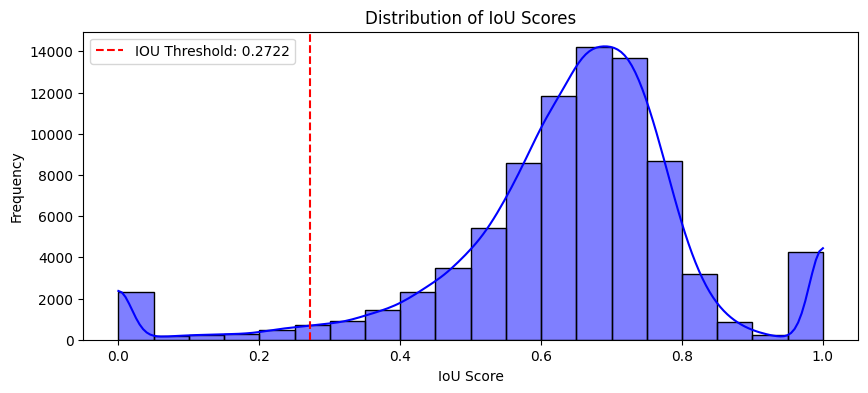

In [ ]:
# Calculate the mean IoU
mean_iou = df['IoU'].mean()
print(f'Mean IoU: {mean_iou:.4f}')

# Calculate the standard deviation of the IoU
std_iou = df['IoU'].std()
print(f'Standard Deviation of IoU: {std_iou:.4f}')

# Calculate the IOU threshold that is two standard deviations below the mean
iou_threshold = mean_iou - 2 * std_iou
print(f'IOU Threshold: {iou_threshold:.4f}')

# Calculate the number of IoU values below the threshold
below_threshold_count = df[df['IoU'] < iou_threshold].shape[0]
print(f'Number of IoU values below the threshold: {below_threshold_count}')

# Calculate the percentage of IoU values below the threshold
percentage_below_threshold = (below_threshold_count / len(df)) * 100
print(f'Percentage of IoU values below the threshold: {percentage_below_threshold:.2f}%')

# Plotting
plt.figure(figsize=(10, 4))
sns.histplot(df['IoU'], kde=True, color='blue', binwidth=0.05)

# Adding titles and labels
plt.title('Distribution of IoU Scores')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')

# Annotating the IOU threshold
plt.axvline(x=iou_threshold, color='red', linestyle='--', label=f'IOU Threshold: {iou_threshold:.4f}')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Get a subset of the data where the IoU is below the threshold keep fwp
fwps_subset= df[df['IoU'] > iou_threshold]['fwp'].values.tolist()

# Get the list of all folders and sub-folders in the dataset
folders = glob.glob('ramp_data_yolo/**/', recursive=True)
folders = [folder.strip('/') for folder in folders]

# Create a new folder for each folder in the dataset
for folder in folders:
    if not os.path.exists(folder.replace('ramp_data_yolo', 'ramp_data_yolo_iou')):
        os.makedirs(folder.replace('ramp_data_yolo', 'ramp_data_yolo_iou'))

# Copy the images to the new folder
for fwp in fwps_subset:
    print(fwp)
    os.system(f'cp {fwp} {fwp.replace("ramp_data_yolo", "ramp_data_yolo_iou")}')
    os.system(f'cp {fwp.replace("images", "labels").replace(".jpg", ".txt")} {fwp.replace("ramp_data_yolo", "ramp_data_yolo_iou").replace(".jpg", ".txt").replace("images", "labels")}')

### YOLO-DATA-V3 ###

In [ ]:
def convert_to_3857(tif_file, verbose=False):
    with rasterio.open(tif_file) as src:
        original_transform = src.transform
        original_crs = src.crs
        new_crs = 'EPSG:3857'
        transformer = Transformer.from_crs(src.crs, 'EPSG:3857', always_xy='True')

        # Transform the origin point
        new_origin_x, new_origin_y = transformer.transform(original_transform.c, original_transform.f)

        # Transform a point one pixel away in the x and y directions
        new_x_point_x, new_x_point_y = transformer.transform(original_transform.c + original_transform.a, original_transform.f + original_transform.b)
        new_y_point_x, new_y_point_y = transformer.transform(original_transform.c + original_transform.d, original_transform.f + original_transform.e)

        # Calculate new scale factors and translation from transformed points
        new_a = new_x_point_x - new_origin_x  # Scale in x direction
        new_e = new_y_point_y - new_origin_y  # Scale in y direction
        new_transform = Affine(new_a, original_transform.b, new_origin_x,
                            original_transform.d, new_e, new_origin_y)

        # Print results if verbose is True
        if verbose:
            print(f'file: {os.path.basename(tif_file)}')
            print(f'{src.crs}: {[getattr(original_transform, attr) for attr in "abcdef"]}')
            print(f'{new_crs}: {[getattr(new_transform, attr) for attr in "abcdef"]}\n')

        return [getattr(new_transform, attr) for attr in "abcdef"]

files = glob.glob('ramp_data/*/source/*.tif')

fns, x_scales, y_scales = [], [], []

for n, file in enumerate(files):
    print(f'Processing file {n+1}/{len(files)}')
    new_transform = convert_to_3857(file)

    # Append the results to the lists
    fns.append(os.path.basename(file))
    x_scales.append(abs(round(new_transform[0], 2)))
    y_scales.append(abs(round(new_transform[4], 2)))

# Calculate the number of files with x and y scales below 0.4
x_below_threshold = sum([1 for x in x_scales if x < 0.4])
y_below_threshold = sum([1 for y in y_scales if y < 0.4])

# Calculate the percentage of files with x and y scales below 0.4
x_percentage_below_threshold = (x_below_threshold / len(x_scales)) * 100
y_percentage_below_threshold = (y_below_threshold / len(y_scales)) * 100

# Print the results
print(f'Number of files with x scales below 0.4: {x_below_threshold}')
print(f'Percentage of files with x scales below 0.4: {x_percentage_below_threshold:.2f}%')
print(f'Number of files with y scales below 0.4: {y_below_threshold}')
print(f'Percentage of files with y scales below 0.4: {y_percentage_below_threshold:.2f}%')

# Create a dataframe with the x and y scales
df_scales = pd.DataFrame({'Filename': fns, 'X Scales': x_scales, 'Y Scales': y_scales})

df_scales

ZeroDivisionError: division by zero

In [ ]:
# Generate a basefilename from the filename
df_scales['Filename'] = df_scales['Filename'].str.replace('.tif', '.jpg')

# Merge dataframes keep only when df and df_tif have the same filename
df_merge = pd.merge(df, df_scales, on='Filename', how='inner')

# Keep only the rows where the scale is below 0.4 in both x and y directions
df_merge = df_merge[(df_merge['X Scales'] < 0.4) & (df_merge['Y Scales'] < 0.4)]

# Keep only the rows where IOU is above the threshold
df_merge = df_merge[df_merge['IoU'] > iou_threshold]

# Print the merged dataframe
print(df_merge)

# Print total number of files
print(f'Total number of files: {len(df_merge)}')

                                       Filename  IoU   F1  Precision  Recall  \
0      226f2ee9-b371-4743-a955-5c7f23935d97.jpg  0.0  0.0        0.0     0.0   
1      5cfa808a-8145-4d21-98eb-b63669f1be06.jpg  0.0  0.0        0.0     0.0   
2      8ec0d6e3-2f80-48d4-bfca-254b9c098f32.jpg  0.0  0.0        0.0     0.0   
3      343f769a-e7fa-4d5e-88ea-8bff4d95ea1e.jpg  0.0  0.0        0.0     0.0   
6      6a35b474-1db0-4b0c-b4cd-745ad8ced072.jpg  0.0  0.0        0.0     0.0   
...                                         ...  ...  ...        ...     ...   
83206  84825d2b-cbd8-49d8-b8fe-70eaa5995fba.jpg  1.0  0.0        0.0     0.0   
83207  dc560774-8f1e-4b2d-9044-5764c96813eb.jpg  1.0  0.0        0.0     0.0   
83209  a6aae303-c3be-4905-a69e-810052a204ec.jpg  1.0  0.0        0.0     0.0   
83210  314ef098-a623-464d-b8ba-8e15141e6115.jpg  1.0  0.0        0.0     0.0   
83211  d99ec1e2-6203-4571-b5c3-9cdaaa82aa3f.jpg  1.0  0.0        0.0     0.0   

       Intersection  Union  Average Are

In [ ]:
# Get the list of all folders and sub-folders in the dataset
folders = glob.glob('ramp_data_yolo/**/', recursive=True)
folders = [folder.strip('/') for folder in folders]

# Create a new folder for each folder in the dataset
for folder in folders:
    if not os.path.exists(folder.replace('ramp_data_yolo', 'ramp_data_yolo_iou_scale')):
        os.makedirs(folder.replace('ramp_data_yolo', 'ramp_data_yolo_iou_scale'))

# Copy the images to the new folder
for fwp in df_merge['fwp'].values:
    print(fwp)
    os.system(f'cp {fwp} {fwp.replace("ramp_data_yolo", "ramp_data_yolo_iou_scale")}')
    os.system(f'cp {fwp.replace("images", "labels").replace(".jpg", ".txt")} {fwp.replace("ramp_data_yolo", "ramp_data_yolo_iou_scale").replace(".jpg", ".txt").replace("images", "labels")}')

# Print the count of the number of jpgs in the new folder
print(len(glob.glob('ramp_data_yolo_iou_scale/*/images/*.jpg', recursive=True)))

# Print the count of the number of txts in the new folder
print(len(glob.glob('ramp_data_yolo_iou_scale/*/labels/*.txt', recursive=True)))

ramp_data_yolo/train/images/226f2ee9-b371-4743-a955-5c7f23935d97.jpg
ramp_data_yolo/train/images/5cfa808a-8145-4d21-98eb-b63669f1be06.jpg
ramp_data_yolo/train/images/8ec0d6e3-2f80-48d4-bfca-254b9c098f32.jpg
ramp_data_yolo/val/images/343f769a-e7fa-4d5e-88ea-8bff4d95ea1e.jpg
ramp_data_yolo/test/images/6a35b474-1db0-4b0c-b4cd-745ad8ced072.jpg
ramp_data_yolo/test/images/5cc92b92-1f16-4426-b5d5-ceba5fd02409.jpg
ramp_data_yolo/train/images/e695d48f-651d-4240-9d24-4d83e3828b29.jpg
ramp_data_yolo/train/images/52578be3-3c3f-4003-bb5c-7ada5bf79dba.jpg
ramp_data_yolo/train/images/1a7f7fbe-c9aa-4189-acf9-eec205449083.jpg
ramp_data_yolo/train/images/7a4c94cb-9e4d-4f51-9b0c-12102629ea16.jpg
ramp_data_yolo/test/images/76043b88-c6fa-4740-820b-87305a022eb7.jpg
ramp_data_yolo/train/images/89fb1f39-b9fd-4143-ae1b-88a3bb181775.jpg
ramp_data_yolo/train/images/09c9a8da-a7bc-4c39-9f55-61361ec1a41e.jpg
ramp_data_yolo/train/images/2eeb6350-5d6e-470c-ba56-5efb6eafb65f.jpg
ramp_data_yolo/train/images/a47d143e-79

In [ ]:
SOURCE = 'ramp_data_yolo'
DESTINATION = 'ramp_data_yolo_iou10_scale'

# Keep only the rows where IOU is above the threshold
df_merge_2 = df_merge[df_merge['IoU'] > 0.4].copy()

# Print the number of items in the dataframe
print(len(df_merge_2))

def generate_new_dataset(df, SOURCE, DESTINATION):
    # Get the list of all folders and sub-folders in the dataset
    folders = glob.glob(f'{SOURCE}/**/', recursive=True)
    folders = [folder.strip('/') for folder in folders]

    # Create a new folder for each folder in the dataset
    for folder in folders:
        if not os.path.exists(folder.replace(SOURCE, DESTINATION)):
            os.makedirs(folder.replace(SOURCE, DESTINATION))

    # Copy the images to the new folder
    for fwp in df['fwp'].values:
        print(fwp)
        os.system(f'cp {fwp} {fwp.replace(SOURCE, DESTINATION)}')
        os.system(f'cp {fwp.replace("images", "labels").replace(".jpg", ".txt")} \
                  {fwp.replace(SOURCE, DESTINATION).replace(".jpg", ".txt").replace("images", "labels")}')

    # Count the number of jpgs in the new folder
    jpg_count = len(glob.glob(f'{DESTINATION}/*/images/*.jpg', recursive=True))

    # Count the number of txts in the new folder
    txt_count = len(glob.glob(f'{DESTINATION}/*/labels/*.txt', recursive=True))

    return jpg_count, txt_count

# Call the function
jpg_count, txt_count = generate_new_dataset(df_merge_2, SOURCE, DESTINATION)

print(jpg_count, txt_count)


51354
ramp_data_yolo/train/images/6a50646e-8051-40a6-81f4-478d55690aeb.jpg
ramp_data_yolo/test/images/ff57aa51-998a-450b-bbd6-ca4e1b405b0c.jpg
ramp_data_yolo/train/images/d5aaca94-edb9-44e0-9808-46347cb00e16.jpg
ramp_data_yolo/train/images/b150f70f-5bdd-471f-9e4b-73d4e53eeb1d.jpg
ramp_data_yolo/val/images/ef0ac8c7-007d-4db4-b41a-f428d5a5e462.jpg
ramp_data_yolo/val/images/52bd9e57-bcb8-41d2-8062-47aea1d1cd7b.jpg
ramp_data_yolo/train/images/97bc4ef3-3112-4507-9ec1-12a2c78cfea4.jpg
ramp_data_yolo/train/images/1d787c0f-227b-4717-890d-495c489e095e.jpg
ramp_data_yolo/train/images/5a534d7f-4596-4dd7-9c6a-64103cea6499.jpg
ramp_data_yolo/train/images/be633201-b366-4495-85ac-5a6666af1841.jpg
ramp_data_yolo/train/images/00d6b746-63e3-4cae-8bca-b192114ca14c.jpg
ramp_data_yolo/test/images/73ff78fb-2901-4724-9b78-f32c63b347c9.jpg
ramp_data_yolo/train/images/5853dc78-501c-42cf-9078-b3bde1f5fe0d.jpg
ramp_data_yolo/val/images/9c710a31-7779-41e5-89a5-2dcbd8257451.jpg
ramp_data_yolo/train/images/0195461d